In [66]:
# General imports
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from astropy.io import fits
from astropy.table import Table, join
import os
os.chdir("/Users/keith/astr/research_astr/roman_grism_sim/ultra_smooth_lambda_dependent/fits")

# Pretty plots
import matplotlib
matplotlib.rcParams["figure.figsize"] = (11,6)
matplotlib.rcParams["image.interpolation"] = "nearest"
matplotlib.rcParams["image.origin"] = "lower"

# Grizli
from grizli.model import GrismFLT

# pysynphot
import pysynphot as S

# WebbPSF
import webbpsf
import webbpsf.roman

In [67]:
# Read SED template; using G0V star template
df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

spec = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/ukg0v.dat", format="ascii")
src = S.ArraySpectrum(wave=spec["col1"], flux=spec["col2"], waveunits="angstroms", fluxunits="flam")
src = src.renorm(6, "abmag", bp)
src.convert("flam")

spec = spec[1770:3771] # truncate spectrum to 10000-20000 angstroms


# PSF
wfi = webbpsf.roman.WFI()
# webbpsf.setup_logging("Error")

In [68]:
# initialize grizli
pad = 100
roman = GrismFLT(direct_file="empty_direct.fits", seg_file="empty_seg.fits", pad=pad)

# add psf direct image and seg map
# roman.direct.data["SCI"] = psf_direct.astype("float32")
# roman.seg = np.where(roman.direct.data["SCI"], 1, 0).astype("float32")

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
empty_direct.fits / Pad ref HDU with 264 pixels
empty_direct.fits / blot segmentation empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [69]:
def chunk(start_wave, end_wave):
    start_index = int((start_wave - 10000) / 5)
    end_index = int((end_wave - 10000) / 5) + 1

    chunk_spec = np.asarray(spec[start_index:end_index])

    return chunk_spec

def dispersion_model(pad_region, nbins, return_input=False):

    pad_region = int(pad_region) # overlap extent; data points
    nbins = int(nbins) # number of bins

    window_x = np.linspace(0, np.pi, pad_region)
    front_y = (1-np.cos(window_x)) / 2
    back_y = 1 - front_y

    bins = np.linspace(10000, 20000, nbins + 1)

    piecemeal_sim = np.zeros((4288,4288))

    input_catcher = []
    
    for ii, start_wave in enumerate(bins[:-1]):

        psf = wfi.calc_psf(monochromatic=(start_wave * (10**-10)), fov_pixels=182, oversample=1, source=src)[0].data
        half_psf_thumb = int(psf.shape[0] / 2) # Used for indexing; center_pixel plus/minus half_psf_thumb(nail)

        direct = np.zeros((4288, 4288))
        direct[(2144-half_psf_thumb): (2144+half_psf_thumb), (2144-half_psf_thumb):(2144+half_psf_thumb)] = psf

        roman.direct.data["SCI"] = direct.astype("float32")
        roman.seg = np.where(roman.direct.data["SCI"], 1, 0).astype("float32")

        end_wave = bins[ii+1]

        start_wave -= (pad_region * 5) * 0.5 # times 5 from indicies to wavelength
        end_wave += ((pad_region - 1) * 5) * 0.5

        if start_wave < 10000:
            start_wave = 10000
        
        if end_wave > 20000:
            end_wave = 20000

        chunk_spec = chunk(start_wave, end_wave) # extract relevant part of spectrum
        wave = chunk_spec["col1"]
        flux = chunk_spec["col2"]

        # apodize
        if start_wave != 10000:
            flux[:pad_region] *= front_y

        if end_wave != 20000:
            flux[-pad_region:] *= back_y

        print("Wave Limits: [{}, {}]".format(wave[0], wave[-1]))

        single_dispersion = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77, is_cgs=True, store=False,
                                                       in_place=False, spectrum_1d=[wave, flux])[1]

        piecemeal_sim += single_dispersion

        apodized_spec = Table([wave, flux], names=("wave","flux"))

        input_catcher.append(apodized_spec)

        del chunk_spec
        del flux
        del wave

    return_collector = []

    if return_input:
        return_collector.append(input_catcher)

    return_collector.append(piecemeal_sim)

    return return_collector

def combine_overlaps(table_1, table_2):

    full_input = join(table_1, table_2, keys='wave', join_type="outer")

    full_input["flux_1"].fill_value = 0
    full_input["flux_2"].fill_value = 0
    full_input = full_input.filled()

    sum = full_input["flux_1"] + full_input["flux_2"]

    sum_table = Table([full_input["wave"], sum], names=["wave", "flux"])

    return sum_table

def simple_extractions(image, sum=True, max=False):
    return_collector = []

    if sum:
        return_collector.append(np.array([image[:, ii].sum() for ii in range(image.shape[1])]))
    
    if max:
        return_collector.append(np.array([image[:, ii].max() for ii in range(image.shape[1])]))

    return return_collector

In [70]:
pad_region = 20
nbins = 20

inputs, sim_result = dispersion_model(pad_region, nbins, return_input=True)

Wave Limits: [10000.0, 10545.0]
Wave Limits: [10450.0, 11045.0]
Wave Limits: [10950.0, 11545.0]
Wave Limits: [11450.0, 12045.0]
Wave Limits: [11950.0, 12545.0]
Wave Limits: [12450.0, 13045.0]
Wave Limits: [12950.0, 13545.0]
Wave Limits: [13450.0, 14045.0]
Wave Limits: [13950.0, 14545.0]
Wave Limits: [14450.0, 15045.0]
Wave Limits: [14950.0, 15545.0]
Wave Limits: [15450.0, 16045.0]
Wave Limits: [15950.0, 16545.0]
Wave Limits: [16450.0, 17045.0]
Wave Limits: [16950.0, 17545.0]
Wave Limits: [17450.0, 18045.0]
Wave Limits: [17950.0, 18545.0]
Wave Limits: [18450.0, 19045.0]
Wave Limits: [18950.0, 19545.0]
Wave Limits: [19450.0, 20000.0]


In [71]:
# Combine all inputs into a single array
for ii in range(len(inputs)):
    if ii == 0:
        full_input = inputs[0]
    else:
        full_input = combine_overlaps(full_input, inputs[ii])

# Perform simple_extractions
extractions = simple_extractions(sim_result, sum=True, max=True)

Text(0.5, 1.0, '')

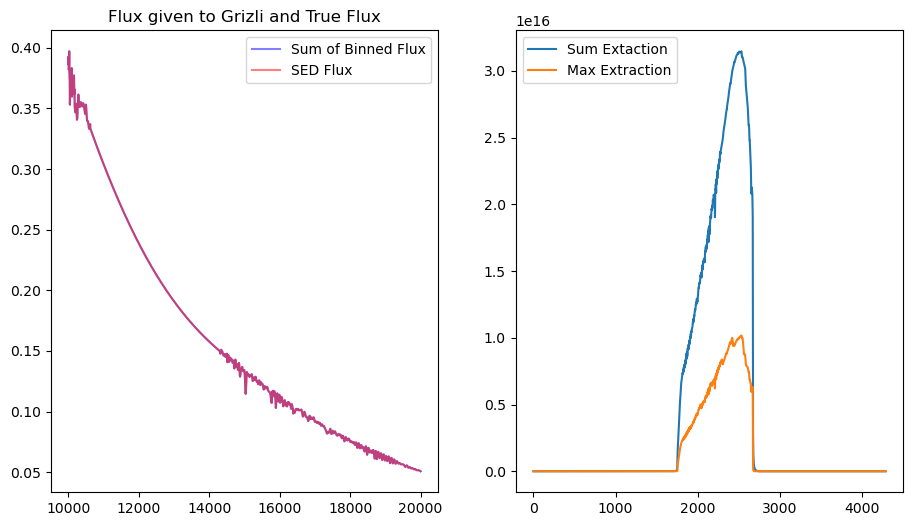

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(full_input["wave"], full_input["flux"], color='b', alpha=0.5, label="Sum of Binned Flux")
ax1.plot(spec["col1"], spec["col2"], color = 'r', alpha=0.5, label="SED Flux")
ax1.legend()
ax1.set_title("Flux given to Grizli and True Flux")

ax2.plot(extractions[0], label="Sum Extaction")
ax2.plot(extractions[1], label="Max Extraction")
ax2.legend()
ax2.set_title("")

In [74]:
truth = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77, is_cgs=True, 
                                   store=False, in_place=False, spectrum_1d=[spec["col1"], spec["col2"]])[1]

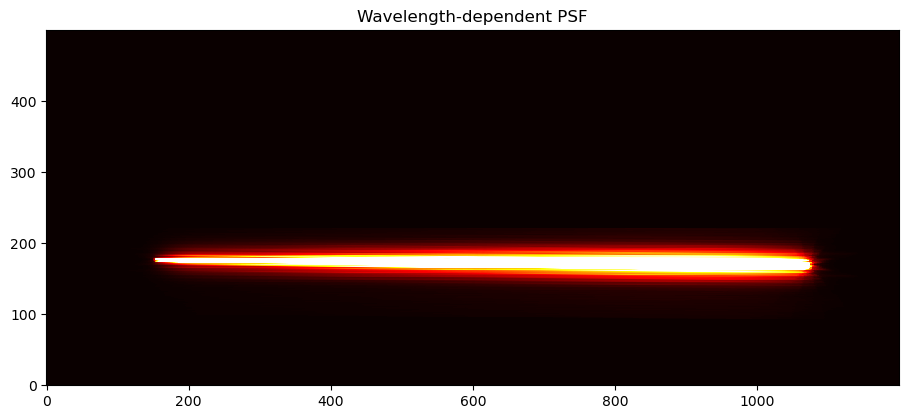

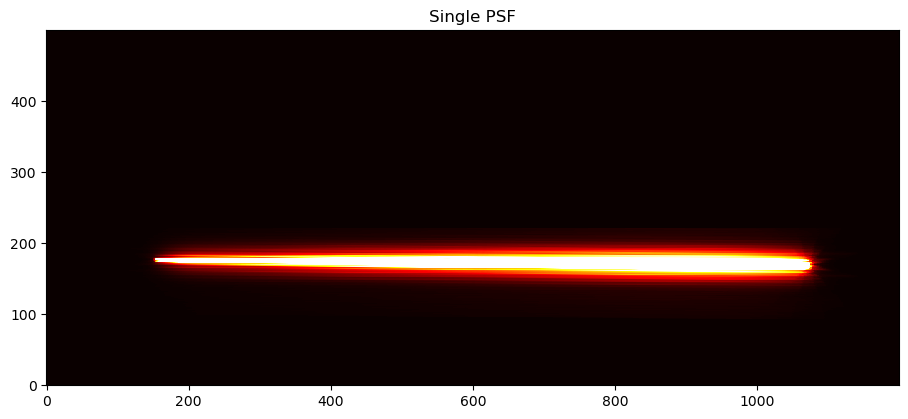

In [78]:
plt.imshow(truth[2000:2500, 1600:2800], vmin=0, vmax=sim_result.max()/100, cmap="hot")
plt.title("Wavelength-dependent PSF")
plt.show()

plt.imshow(truth[2000:2500, 1600:2800], vmin=0, vmax=sim_result.max()/100, cmap="hot")
plt.title("Single PSF")
plt.show()

Text(0.5, 1.0, 'Subtract Wavelength-depdent PSF dispersion from Single PSF disperion')

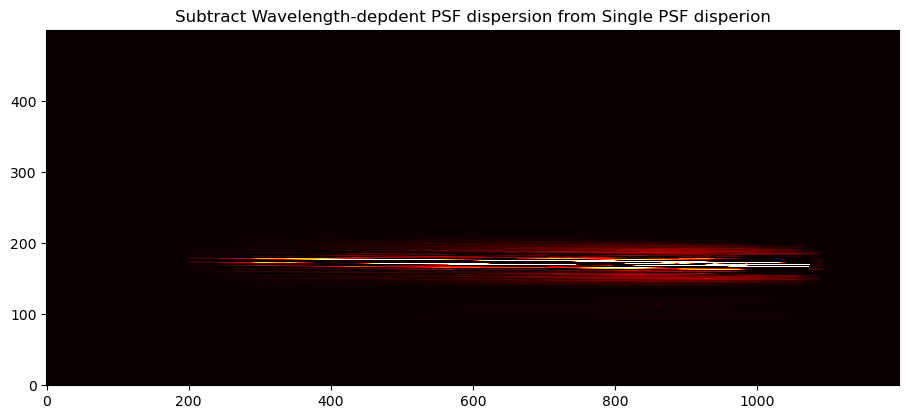

In [77]:
plt.imshow((truth-sim_result)[2000:2500, 1600:2800], vmin=0, vmax=sim_result.max()/100, cmap="hot")
plt.title("Subtract Wavelength-depdent PSF dispersion from Single PSF disperion")

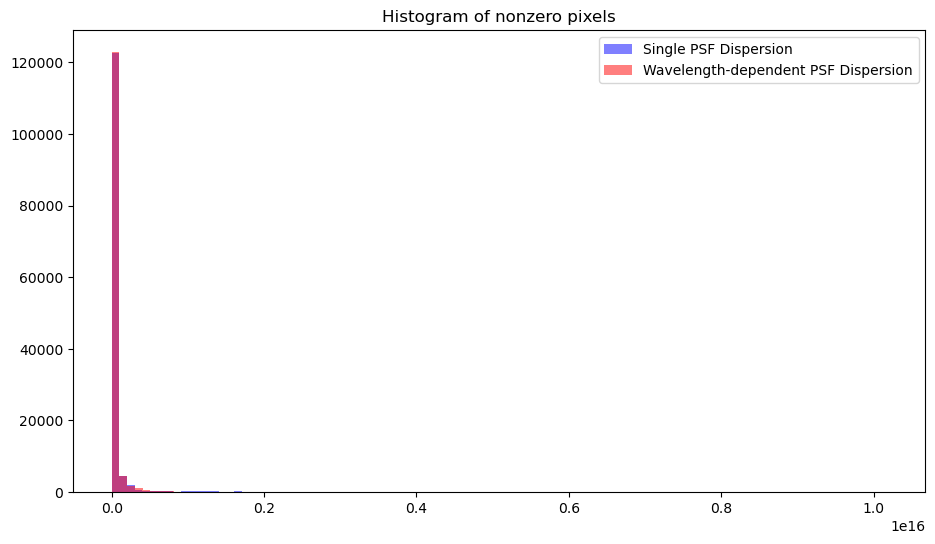

In [ ]:
plt.hist(truth[np.nonzero(truth)].flatten(), bins=100, color="b", alpha=0.5, label="Single PSF Dispersion");
plt.hist(sim_result[np.nonzero(sim_result)].flatten(), bins=100, color="r", alpha=0.5, label="Wavelength-dependent PSF Dispersion");
plt.title("Histogram of nonzero pixels")
plt.legend()